# Clustering of drawn components in galaxy builder

First, say the jupyter magic words 🧙‍

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import the plethora of useful modules we'll need (including some we probably don't)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
from matplotlib.patches import Rectangle as R2
import matplotlib.transforms as transforms
import matplotlib.lines as mlines
import json
from pprint import pprint
from sklearn.feature_extraction import DictVectorizer
from panoptes_aggregation.extractors.shape_extractor import shape_extractor
from panoptes_aggregation.extractors.utilities import annotation_by_task
from panoptes_aggregation.reducers.shape_reducer_dbscan import shape_reducer_dbscan
from panoptes_aggregation.reducers.shape_reducer_hdbscan import shape_reducer_hdbscan
import lib.galaxy_utilities as gu
import wrangle_classifications as wc
import lib.python_model_renderer.render_galaxy as rg
import papermill as pm

Loading NSA catalog


Loading Zooniverse classification dump


Obtaining available frame montages


In [3]:
def _update_patch_transfrom_about_center(self):
    x = self.convert_xunits(self._x0)
    y = self.convert_yunits(self._y0)
    width = self.convert_xunits(self._width)
    height = self.convert_yunits(self._height)
    bbox = transforms.Bbox.from_bounds(x, y, width, height)
    rot_trans = transforms.Affine2D()
    rot_trans.rotate_deg_around(x + 0.5 * width, y + 0.5 * height, self.angle)
    self._rect_transform = transforms.BboxTransformTo(bbox)
    self._rect_transform += rot_trans

Rectangle._update_patch_transform = _update_patch_transfrom_about_center

Which subject should we work on? (parametrised to allow batch running at a later date)

In [4]:
subject_id = 20902041

In [5]:
# Parameters
subject_id = 21096909


Implement a temporary way of reading in data till the zooniverse CSV export is fixed:

In [6]:
with open('tmp_cls_dump.json') as f:
    classifications = json.load(f)
classifications_for_subject = [
    c for c in classifications
    if c['links']['subjects'][0] == str(subject_id)
]
print('Found {} classifications for subject_id {}'.format(
    len(classifications_for_subject),
    subject_id,
))
annotations_for_subject = [i['annotations'] for i in classifications_for_subject]

Found 31 classifications for subject_id 21096909


Grab the galaxy data (and classification data) for this galaxy

In [7]:
print('Getting galaxy data')
gal, angle = gu.get_galaxy_and_angle(subject_id)
url = gu.getUrl(subject_id)
pic_array, deprojected_image = gu.get_image(gal, subject_id, angle)
# classifications = gu.classifications
# classifications_for_subject = classifications['subject_ids'] == subject_id
# annotations_for_subject = [
#     eval(foo) for foo in
#     classifications_for_subject
# ]

Getting galaxy data
Working on galaxy 21096909
	- USING MONTAGED IMAGE
	- Getting galaxy rotation


/Users/tlingard/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Grab the galaxy's PSF (from the data used in online model rendering)

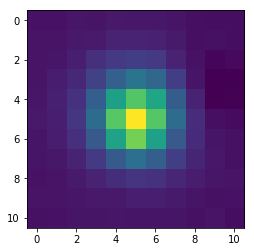

In [8]:
psf = gu.get_psf(subject_id)
plt.imshow(psf); None

Grab the difference JSON data for this subject (used later for rendering)

In [9]:
diff_data = gu.get_image_data(subject_id)

Iterate through the annotations and grab the classifications for disks, bulges and bars:

In [10]:
disks = [a[0] for a in annotations_for_subject if len(a) == 4]
bulges = [a[1] for a in annotations_for_subject if len(a) == 4]
bars = [a[2] for a in annotations_for_subject if len(a) == 4]

Let's have a look at these classifications!

12


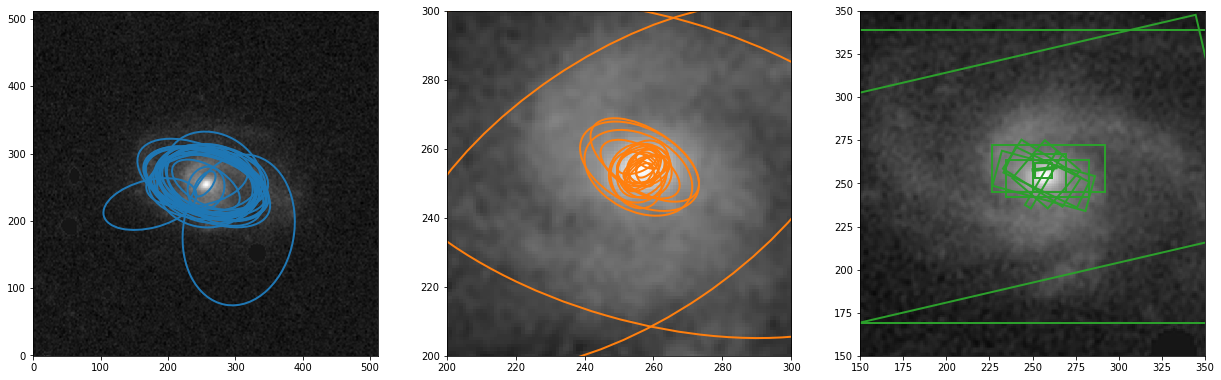

In [11]:
def plot_config(n):
    plt.subplot(n)
    plt.imshow(pic_array, origin='lower', cmap='gray')
    return plt.gca()

plt.figure(figsize=(21, 8))
for i, comp in enumerate((disks, bulges)):
    ax = plot_config(131 + i)
    for c_ in comp:
        try:
            c = c_['value'][0]['value'][0]
            ax.add_artist(Ellipse(
                xy=(c['x'], c['y']),
                width=c['rx'], height=c['ry'], angle=-c['angle'],
                ec='C{}'.format(i), fc='none', lw=2
            ))
        except IndexError: pass
plt.xlim(200, 300); plt.ylim(200, 300)

ax = plot_config(133)
c = 0
for bar in bars:
    try:
        b = bar['value'][0]['value'][0]
        r = Rectangle(
            xy=(b['x'], b['y']),
            width=b['width'], height=b['height'],
            angle=b['angle'],
            ec='C2', fc='none', lw=2
        )
        ax.add_patch(r)
        c += 1
    except IndexError: pass
plt.xlim(150, 350); plt.ylim(150, 350)
print(c)

We need to wrangle the classifications into a form the aggregation code accepts. This involves
- moving sliders to drawing sub-tasks
- move all shapes to the zero-th frame
- scale the radius according to the radius slider
- move the drawn shape out of the combo task, so it's on its own

This is all done using the `convert_shape` function inside `wrangle_classifications.py`

In [12]:
converted_disks = [wc.convert_shape(d) for d in disks]
converted_bulges = [wc.convert_shape(d) for d in bulges]
converted_bars = [wc.convert_shape(d, bar=True) for d in bars]

Let's have a look at what this transformation did:

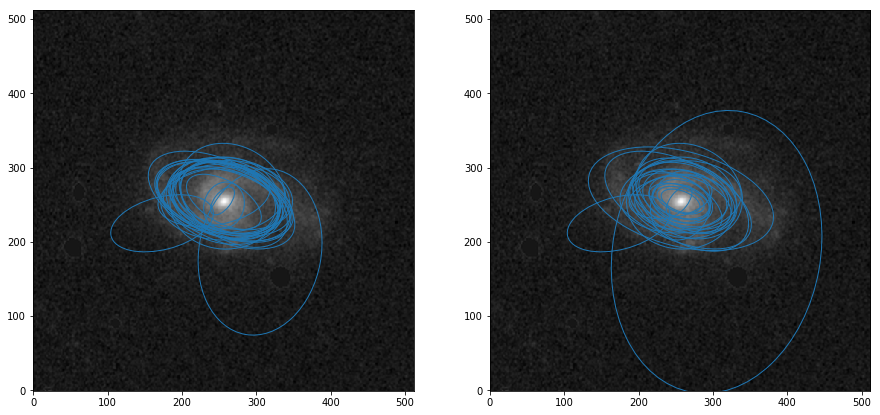

In [13]:
plt.figure(figsize=(15, 7))
ax = plot_config(121)
for d_ in disks:
    try:
        d = d_['value'][0]['value'][0]
        e = Ellipse(
            xy=(d['x'], d['y']),
            width=d['rx'], height=d['ry'], angle=-d['angle'],
            ec='C0', fc='none',
        )
        ax.add_artist(e)
    except IndexError: pass

ax = plot_config(122)
for d_ in converted_disks:
    try:
        d = d_['value'][0]
        e = Ellipse(
            xy=(d['x'], d['y']),
            width=d['rx'], height=d['ry'], angle=-d['angle'],
            ec='C0', fc='none',
        )
        ax.add_artist(e)
    except IndexError: pass

Define keyword arguments to be used by the aggregation extractor, and perform the reduction. More info can be found [here](https://aggregation-caesar.zooniverse.org/README.html)

In [14]:
kwargs_extractor = {
    'task': 'disk', 'shape': 'ellipse',
    'details': {'disk_tool0': [None, 'slider_extractor']},
}
extracted_disks = [
    shape_extractor(
        annotation_by_task({ 'annotations': [d] }),
        **kwargs_extractor
    )
    for d in converted_disks
]

Perform the aggregation reduction!

In [15]:
kwargs_reducer = {
    'shape': 'ellipse',
    'details': {'disk_tool0': [None, 'slider_reducer']},
    'eps': 70, 'symmetric': True, 'min_samples': 5,
}
disk_clustering_result = shape_reducer_dbscan(
    extracted_disks,
    **kwargs_reducer,
)['frame0']

And plot the output clusters!

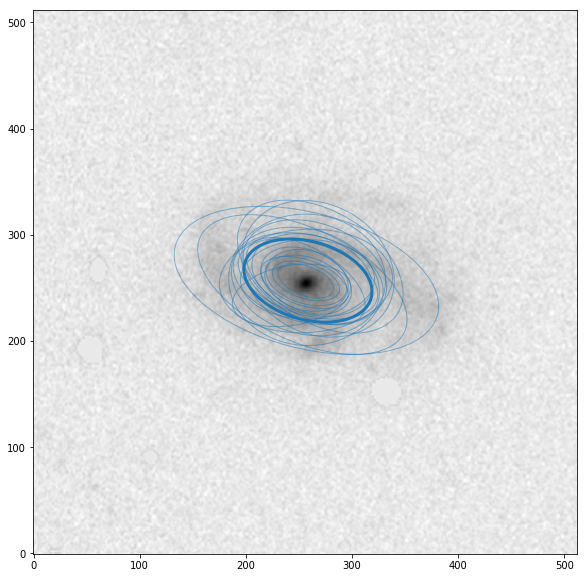

In [16]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
plt.imshow(pic_array, origin='lower', cmap='gray_r')
for i in range(len(disk_clustering_result['disk_tool0_ellipse_rx'])):
    label = disk_clustering_result['disk_tool0_cluster_labels'][i]
    # ignore outliers
    if label < 0:
        continue
    try:
        e = Ellipse(
            xy=(
                disk_clustering_result['disk_tool0_ellipse_x'][i],
                disk_clustering_result['disk_tool0_ellipse_x'][i]
            ),
            width=disk_clustering_result['disk_tool0_ellipse_rx'][i],
            height=disk_clustering_result['disk_tool0_ellipse_ry'][i],
            angle=-disk_clustering_result['disk_tool0_ellipse_angle'][i],
            fc='none', ec='C{}'.format((label) % 10),
            alpha=0.5,
        )
        ax.add_artist(e)
    except IndexError:
        pass
    except KeyError as e:
        print(d)
        raise(e)

for label in np.unique(disk_clustering_result['disk_tool0_cluster_labels']):
    if label > -1:
        final_disk = Ellipse(
            xy=(disk_clustering_result['disk_tool0_clusters_x'][label], disk_clustering_result['disk_tool0_clusters_y'][label]),
            width=disk_clustering_result['disk_tool0_clusters_rx'][label],
            height=disk_clustering_result['disk_tool0_clusters_ry'][label],
            angle=-disk_clustering_result['disk_tool0_clusters_angle'][label],
            ec='C{}'.format(label),
            linewidth=3,
            fc='none',
        )

        ax.add_artist(final_disk)

In [17]:
kwargs_extractor = {
    'task': 'bulge', 'shape': 'ellipse',
    'details': {'bulge_tool0': [None, 'slider_extractor', 'slider_extractor']},
}
kwargs_reducer = {
    'shape': 'ellipse',
    'details': {'bulge_tool0': [None, 'slider_reducer', 'slider_reducer']},
    'eps': 30, 'symmetric': True, 'min_samples': 5,
}
bulge_clustering_result = shape_reducer_dbscan(
    [
        shape_extractor(
            annotation_by_task({ 'annotations': [b] }),
            **kwargs_extractor
        )
        for b in converted_bulges
    ],
    **kwargs_reducer,
)['frame0']

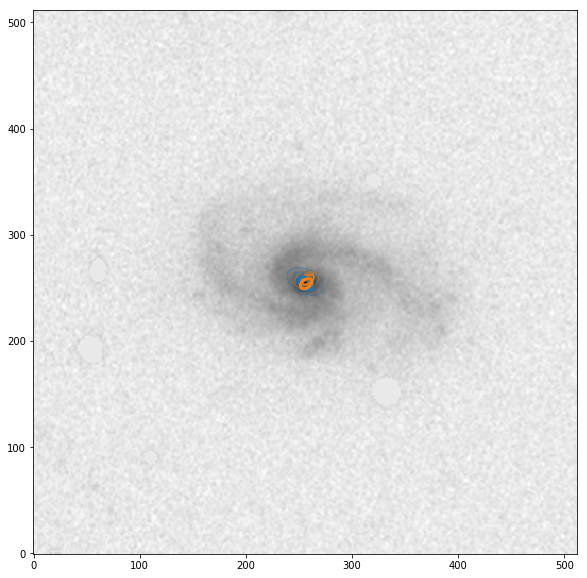

In [18]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
plt.imshow(pic_array, origin='lower', cmap='gray_r')
for i in range(len(bulge_clustering_result['bulge_tool0_ellipse_rx'])):
    label = bulge_clustering_result['bulge_tool0_cluster_labels'][i]
    # ignore outliers
    if label < 0:
        continue
    try:
        e = Ellipse(
            xy=(
                bulge_clustering_result['bulge_tool0_ellipse_x'][i],
                bulge_clustering_result['bulge_tool0_ellipse_x'][i]
            ),
            width=bulge_clustering_result['bulge_tool0_ellipse_rx'][i],
            height=bulge_clustering_result['bulge_tool0_ellipse_ry'][i],
            angle=-bulge_clustering_result['bulge_tool0_ellipse_angle'][i],
            fc='none', ec='C{}'.format((label) % 10),
            alpha=0.5,
        )
        ax.add_artist(e)
    except IndexError:
        pass
    except KeyError as e:
        print(d)
        raise(e)

for label in np.unique(bulge_clustering_result['bulge_tool0_cluster_labels']):
    if label > -1:
        final_bulge = Ellipse(
            xy=(bulge_clustering_result['bulge_tool0_clusters_x'][label], bulge_clustering_result['bulge_tool0_clusters_y'][label]),
            width=bulge_clustering_result['bulge_tool0_clusters_rx'][label],
            height=bulge_clustering_result['bulge_tool0_clusters_ry'][label],
            angle=-bulge_clustering_result['bulge_tool0_clusters_angle'][label],
            ec='C{}'.format(label),
            linewidth=3,
            fc='none',
        )

        ax.add_artist(final_bulge)

In [19]:
kwargs_extractor = {
    'task': 'bar', 'shape': 'rotateRectangle',
    'details': {'bar_tool0': [None, 'slider_extractor', 'slider_extractor', 'slider_extractor']},
}
kwargs_reducer = {
    'shape': 'rotateRectangle',
    'details': {'bar_tool0': [None, 'slider_reducer', 'slider_reducer', 'slider_reducer']},
    'eps': 50, 'symmetric': True, 'min_samples': 5,
}
bar_clustering_result = shape_reducer_dbscan(
    [
        shape_extractor(
            annotation_by_task({ 'annotations': [b] }),
            **kwargs_extractor
        )
        for b in converted_bars
    ],
    **kwargs_reducer,
)['frame0']

In [20]:
# bar_clustering_result

adding final bar


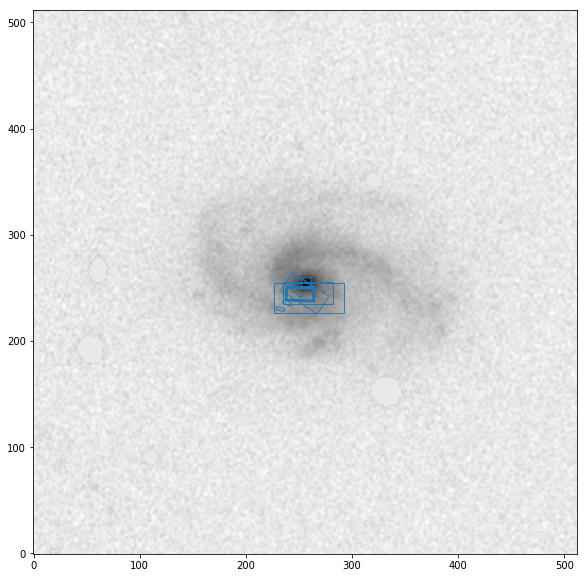

In [21]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
plt.imshow(pic_array, origin='lower', cmap='gray_r')
for i in range(len(bar_clustering_result['bar_tool0_rotateRectangle_x'])):
    label = bar_clustering_result['bar_tool0_cluster_labels'][i]
    # ignore outliers
    if label < 0:
        continue
    try:
        r = Rectangle(
            xy=(
                bar_clustering_result['bar_tool0_rotateRectangle_x'][i],
                bar_clustering_result['bar_tool0_rotateRectangle_x'][i]
            ),
            width=bar_clustering_result['bar_tool0_rotateRectangle_width'][i],
            height=bar_clustering_result['bar_tool0_rotateRectangle_height'][i],
            angle=bar_clustering_result['bar_tool0_rotateRectangle_angle'][i],
            fc='none', ec='C{}'.format((label) % 10),
            alpha=0.9,
        )
        ax.add_patch(r)
    except IndexError:
        pass
    except KeyError as e:
        print(d)
        raise(e)

for label in np.unique(bar_clustering_result['bar_tool0_cluster_labels']):
    if label > -1:
        print('adding final bar')
        final_bar = Rectangle(
            xy=(
                bar_clustering_result['bar_tool0_clusters_x'][label],
                bar_clustering_result['bar_tool0_clusters_x'][label]
            ),
            width=bar_clustering_result['bar_tool0_clusters_width'][label],
            height=bar_clustering_result['bar_tool0_clusters_height'][label],
            angle=bar_clustering_result['bar_tool0_clusters_angle'][label],
            ec='C{}'.format(label),
            linewidth=3,
            fc='none',
        )
        ax.add_patch(final_bar)

## Model Rendering

For simplicity, we'll only care about the "zeroth" cluster label.

Let's render the resulting galaxy and see what it looks like!

First, we need to transform our object back from Zooniverse image space to the original data space (512x512 image to 141x141)

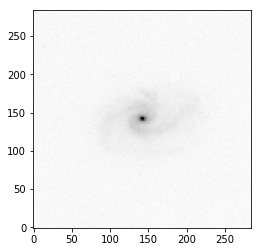

In [22]:
diff_data = gu.get_image_data(subject_id)
galaxy_data_flipped = np.array(diff_data['imageData'])
_ = plt.imshow(galaxy_data_flipped, cmap='gray_r', origin='lower')

It's worth noting that the y-axis is flipped from the image used before (which is the image shown to volunteers).

In [23]:
galaxy_data = galaxy_data_flipped[::-1]
size_diff = diff_data['width'] / diff_data['imageWidth']

Now we'll compile some parameters needed for model rendering:

First the Disk component

In [24]:
rEff_disk = max(
    disk_clustering_result['disk_tool0_clusters_rx'][0],
    disk_clustering_result['disk_tool0_clusters_ry'][0],
)
axRatio_disk = disk_clustering_result['disk_tool0_clusters_rx'][0] \
    / disk_clustering_result['disk_tool0_clusters_ry'][0]

roll_disk = disk_clustering_result['disk_tool0_clusters_angle'][0] \
    + (0 if axRatio_disk > 1 else 90)
axRatio_disk = (1 / axRatio_disk if axRatio_disk > 1 else axRatio_disk)

In [25]:
disk_to_render = {
    'mu': np.array((
        disk_clustering_result['disk_tool0_clusters_x'][0], disk_clustering_result['disk_tool0_clusters_y'][0]
    )) * size_diff,
    'roll': np.deg2rad(roll_disk),
    'rEff': rEff_disk * size_diff,
    'axRatio': axRatio_disk,
    'c': 2,
    'i0': disk_clustering_result['disk_tool0_clusters_details'][0][1]['slider_mean'],
    'n': 1
}
print('Disk parameters:')
pprint(disk_to_render)

Disk parameters:
{'axRatio': 0.5967036481498479,
 'c': 2,
 'i0': 0.2804761904761905,
 'mu': array([143.3278788 , 142.46654245]),
 'n': 1,
 'rEff': 68.51816420129614,
 'roll': 0.270543487351641}


Then the bulge component

In [26]:
rEff_bulge = max(
    bulge_clustering_result['bulge_tool0_clusters_rx'][0],
    bulge_clustering_result['bulge_tool0_clusters_ry'][0],
)
axRatio_bulge = bulge_clustering_result['bulge_tool0_clusters_rx'][0] \
    / bulge_clustering_result['bulge_tool0_clusters_ry'][0]

roll_bulge = bulge_clustering_result['bulge_tool0_clusters_angle'][0] \
    + (0 if axRatio_bulge > 1 else 90)
axRatio_bulge = (1 / axRatio_bulge if axRatio_bulge > 1 else axRatio_bulge)

In [27]:
bulge_to_render = {
    'mu': np.array((
        bulge_clustering_result['bulge_tool0_clusters_x'][0], bulge_clustering_result['bulge_tool0_clusters_y'][0]
    )) * size_diff,
    'roll': np.deg2rad(roll_bulge),
    'rEff': rEff_bulge * size_diff,
    'axRatio': axRatio_bulge,
    'c': 2,
    'i0': bulge_clustering_result['bulge_tool0_clusters_details'][0][1]['slider_mean'],
    'n': bulge_clustering_result['bulge_tool0_clusters_details'][0][2]['slider_mean'],
}
print('Bulge parameters:')
pprint(bulge_to_render)

Bulge parameters:
{'axRatio': 0.652993366114909,
 'c': 2,
 'i0': 0.77875,
 'mu': array([142.3575822 , 140.95849986]),
 'n': 1.2325,
 'rEff': 8.26924090305276,
 'roll': 0.7158467927054742}


In [28]:
disk_arr = rg.sersic_comp(disk_to_render, image_size=diff_data['width'],
                          oversample_n=5)
final_disk_kwargs = {
    'xy': disk_to_render['mu'],
    'width': disk_to_render['rEff'] * disk_to_render['axRatio'],
    'height': disk_to_render['rEff'],
    'angle': 90 - np.rad2deg(disk_to_render['roll']),
    'ec': 'C0',
    'linewidth': 3,
    'fc': 'none',
}

In [29]:
bulge_arr = rg.sersic_comp(bulge_to_render, image_size=diff_data['width'],
                          oversample_n=5)
final_bulge_kwargs = {
    'xy': bulge_to_render['mu'],
    'width': bulge_to_render['rEff'] * bulge_to_render['axRatio'],
    'height': bulge_to_render['rEff'],
    'angle': 90 - np.rad2deg(bulge_to_render['roll']),
    'ec': 'C1',
    'linewidth': 3,
    'fc': 'none',
}

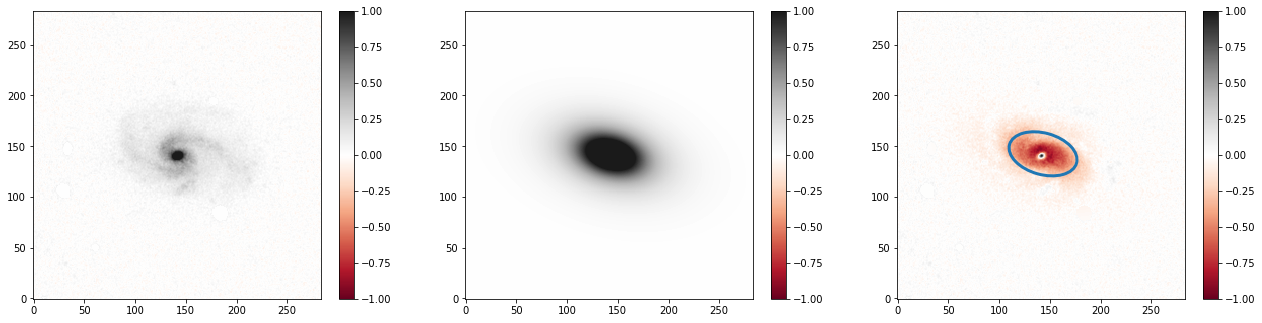

In [30]:
rg.plot_model(disk_arr, psf, galaxy_data)
_ = plt.gca().add_artist(Ellipse(**final_disk_kwargs))

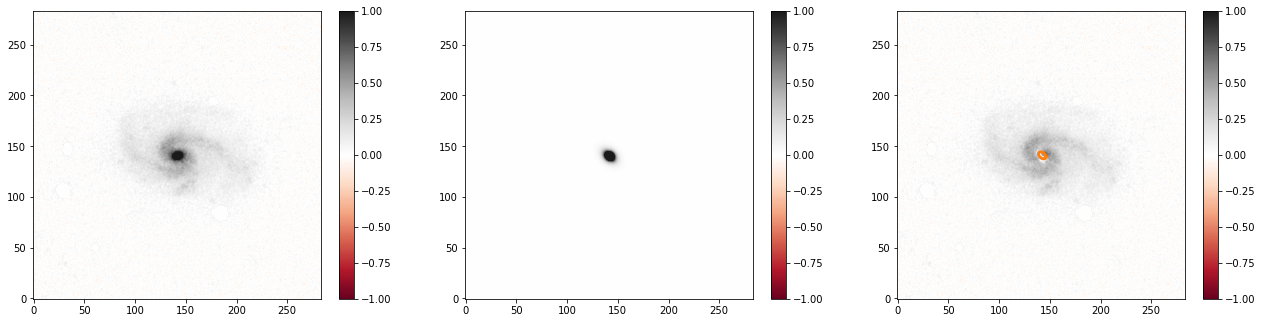

In [31]:
_, a0, a1, a2 = rg.plot_model(bulge_arr, psf, galaxy_data, return_ax=True)
_ = a2.add_artist(Ellipse(**final_bulge_kwargs))

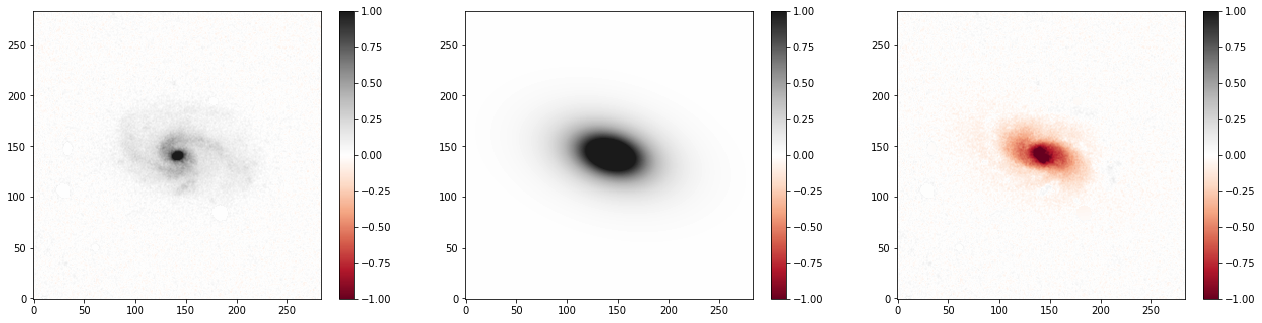

In [32]:
difference_data = rg.plot_model(disk_arr + bulge_arr, psf, galaxy_data)

In [33]:
galaxy_object = gu.get_galaxy_spirals(
    gal, angle, int(subject_id), gu.classifications
)

	 Identified 45 arms
	- Clustering arms
	- Fitting arms and errors


In [34]:
arm_fits = galaxy_object.fit_arms()

In [35]:
# turn off interactive plotting to avoid double plotting
plt.ioff()

<_io.TextIOWrapper name='tmp_cls_dump.json' mode='r' encoding='UTF-8'>

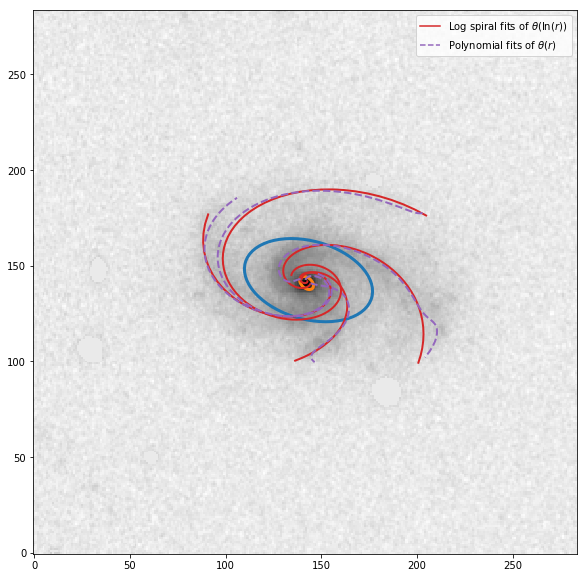

In [36]:
log_fits = [a['log_spiral'] for a in arm_fits]
polynomial_fits = [a['polynomial'] for a in arm_fits]

fig = plt.figure(figsize=(10, 10))
plt.imshow(rg.asinh_stretch(galaxy_data, 0.1), origin='lower', cmap='gray_r')
for i in range(len(log_fits)):
    plt.plot(*log_fits[i].T * size_diff, c='C3', linewidth=2)
    plt.plot(*polynomial_fits[i].T * size_diff, '--', c='C4', linewidth=2)

_ = plt.gca().add_artist(Ellipse(**final_disk_kwargs))
_ = plt.gca().add_artist(Ellipse(**final_bulge_kwargs))

solid_line = mlines.Line2D([], [], color='C3', label=r'Log spiral fits of $\theta(\ln(r))$')
dashed_line = mlines.Line2D([], [], ls='--', color='C4', label=r'Polynomial fits of $\theta(r)$')
plt.legend(handles=[solid_line, dashed_line])
plt.savefig('clustered-components-images/subject-{}'.format(subject_id))
_ = pm.display('clustered_components', f)

In [37]:
# v = DictVectorizer(sparse=False)
# flattened_disks = wc.sklearn_flatten([c['value'][0] for c in converted_disks if len(c['value'])])
# X = v.fit_transform(flattened_disks)
# df_disk = pd.DataFrame(X, columns=v.get_feature_names()).drop(['frame', 'scaleSlider', 'tool'], axis=1)

In [38]:
# from scipy.special import gamma
# from scipy.optimize import curve_fit
# def gd(x, A, alpha, beta):
#     return A * beta**alpha / gamma(alpha) * x**(alpha-1) * np.exp(-beta * x) 

# all_annotations = [c['annotations'] for c in classifications]
# def grab_slider_spread(annotation):
#     try:
#         return [float(j['details'][1]['value']) for j in annotation[3]['value'][0]['value']]
#     except (KeyError, IndexError):
#         return []
# width_sliders = np.array([j for i in all_annotations for j in grab_slider_spread(i)])
# default_mask = width_sliders == 1.0
# min_max_mask = (width_sliders == 0.0) ^ (width_sliders == 2.0)
# width_sliders_filtered = width_sliders[~(default_mask ^ min_max_mask)]

# sigmas = np.sqrt(5 * width_sliders_filtered)